# **Import Library**

In [ ]:
!pip install tensorflow numpy matplotlib scikit-learn kaggle opencv-python
!pip install keras-unet-collection
import os, cv2, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.6 MB/s eta 0:00:00


# **Data Loading**

pastikan kalau ingin run ulang menggunakan username dan api kaggle masing2 ya

In [ ]:
import os

# Mengatur kredensial Kaggle
os.environ['KAGGLE_USERNAME'] = "" #masukan username kaggle
os.environ['KAGGLE_KEY'] = ""  #masukan api key kaggle

# Download dan unzip dataset
!kaggle datasets download -d faizalkarim/flood-area-segmentation -p /content/dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation
License(s): CC0-1.0
  0% 0.00/107M [00:00<?, ?B/s]
100% 107M/107M [00:00<00:00, 1.70GB/s]


# **Preprosessing**

In [ ]:
# IMAGE_DIR → lokasi tempat citra RGB (gambar asli)
# MASK_DIR → lokasi tempat citra mask (label area banjir)
IMAGE_DIR = '/content/dataset/Image'
MASK_DIR  = '/content/dataset/Mask'

# Fungsi ini membaca semua nama file di folder.
def index_by_stem(folder):
    idx = {}
    for f in os.listdir(folder):
        stem, ext = os.path.splitext(f)
        idx[stem] = os.path.join(folder, f)
    return idx

# img_idx → kamus berisi path semua gambar
# mask_idx → kamus berisi path semua mask
img_idx  = index_by_stem(IMAGE_DIR)
mask_idx = index_by_stem(MASK_DIR)

# Ambil hanya pasangan gambar yang memiliki citra asli dan masking (alias yang memiliki pasangan / lengkap)
stems = sorted(list(set(img_idx.keys()) & set(mask_idx.keys())))
# berisi path yang sudah cocok satu-satu (memiliki pasangan citra )
img_paths  = [img_idx[s] for s in stems]
mask_paths = [mask_idx[s] for s in stems]

# melakukan split dimana code awal akan memisahkan 10% untuk test
X_trainval, X_test, y_trainval, y_test = train_test_split(img_paths, mask_paths, test_size=0.10, random_state=42, stratify=None)
# sisa 90% di ambil lagi 20% untuk validasi
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20, random_state=42, stratify=None)
# 70% train 20% validation 10% test

# menampilkan jumlah data outputnya di bawah
len(X_train), len(X_val), len(X_test)


(208, 53, 29)

In [ ]:
# ukuran gambar citra asli dan mask yang akan di gunakan oleh model seluruhnya di setting ke 256x256
IMG_SIZE = (256, 256)
# batch adalah tiap2 data yang akan di load tiap2 iterasi training
BATCH    = 8 # membaca 8 gambar dan 8 mask sekaligus

def read_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_COLOR) # membaca file gambar dari path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # mengubah dari BGR -> RGB
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR) # ubah ukuran ke 256
    img = img.astype(np.float32) / 255.0 #normalisai agar rentang data ada di 0 - 1 agar mempermudah model untuk belajar
    return img

# membaca data maskking
def read_mask(path, target_size=IMG_SIZE):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)         # membaca data maskking
    m = cv2.resize(m, target_size, interpolation=cv2.INTER_NEAREST) # memastikan ukuran 256
    m = (m > 127).astype(np.float32)                   # mengubah ke biner dimana piksel > 127=1 (banjir)  sedangkan <127=0(tidak banjir)
    m = np.expand_dims(m, axis=-1)                     # (256,256,1)
    return m

# augmentasi (menambah variasi gambar secara acak saat training)
def augment(img, msk):
  # Probabilitas 50% untuk flip horizontal dan 30% untuk flip vertikal
    if np.random.rand() < 0.5:
        img  = np.fliplr(img);  msk = np.fliplr(msk)
    if np.random.rand() < 0.3:
        img  = np.flipud(img);  msk = np.flipud(msk)
    return img, msk

# otomatis memuat data batch demi batch saat training
class SegDataset(tf.keras.utils.Sequence):
    def __init__(self, x_paths, y_paths, batch_size=BATCH, augment_on=False):
        self.x = x_paths; self.y = y_paths
        self.bs = batch_size; self.aug = augment_on

    def __len__(self): # jumlah total batch dalam satu epoch
        return int(np.ceil(len(self.x) / self.bs))

    # Ambil daftar path gambar & mask untuk batch tertentu
    def __getitem__(self, idx):
        batch_x = self.x[idx*self.bs:(idx+1)*self.bs]
        batch_y = self.y[idx*self.bs:(idx+1)*self.bs]
        imgs, msks = [], []
        for px, py in zip(batch_x, batch_y):
            img = read_image(px); msk = read_mask(py)
            if self.aug: img, msk = augment(img, msk)
            imgs.append(img); msks.append(msk)
        return np.array(imgs, dtype=np.float32), np.array(msks, dtype=np.float32)

# train_gen citra yang ada augmentasi supaya data latihan bervariasi
train_gen = SegDataset(X_train, y_train, BATCH, augment_on=True)
# yang di bawah ini merupakan data asli (tidak di augmentasi)
val_gen   = SegDataset(X_val,   y_val,   BATCH, augment_on=False)
test_gen  = SegDataset(X_test,  y_test,  BATCH, augment_on=False)


jadi Augmentasi adalah:
proses mengubah citra secara acak agar model mendapatkan variasi visual lebih banyak - tanpa harus menambah dataset baru bisa dengan flip citra bervariasi ber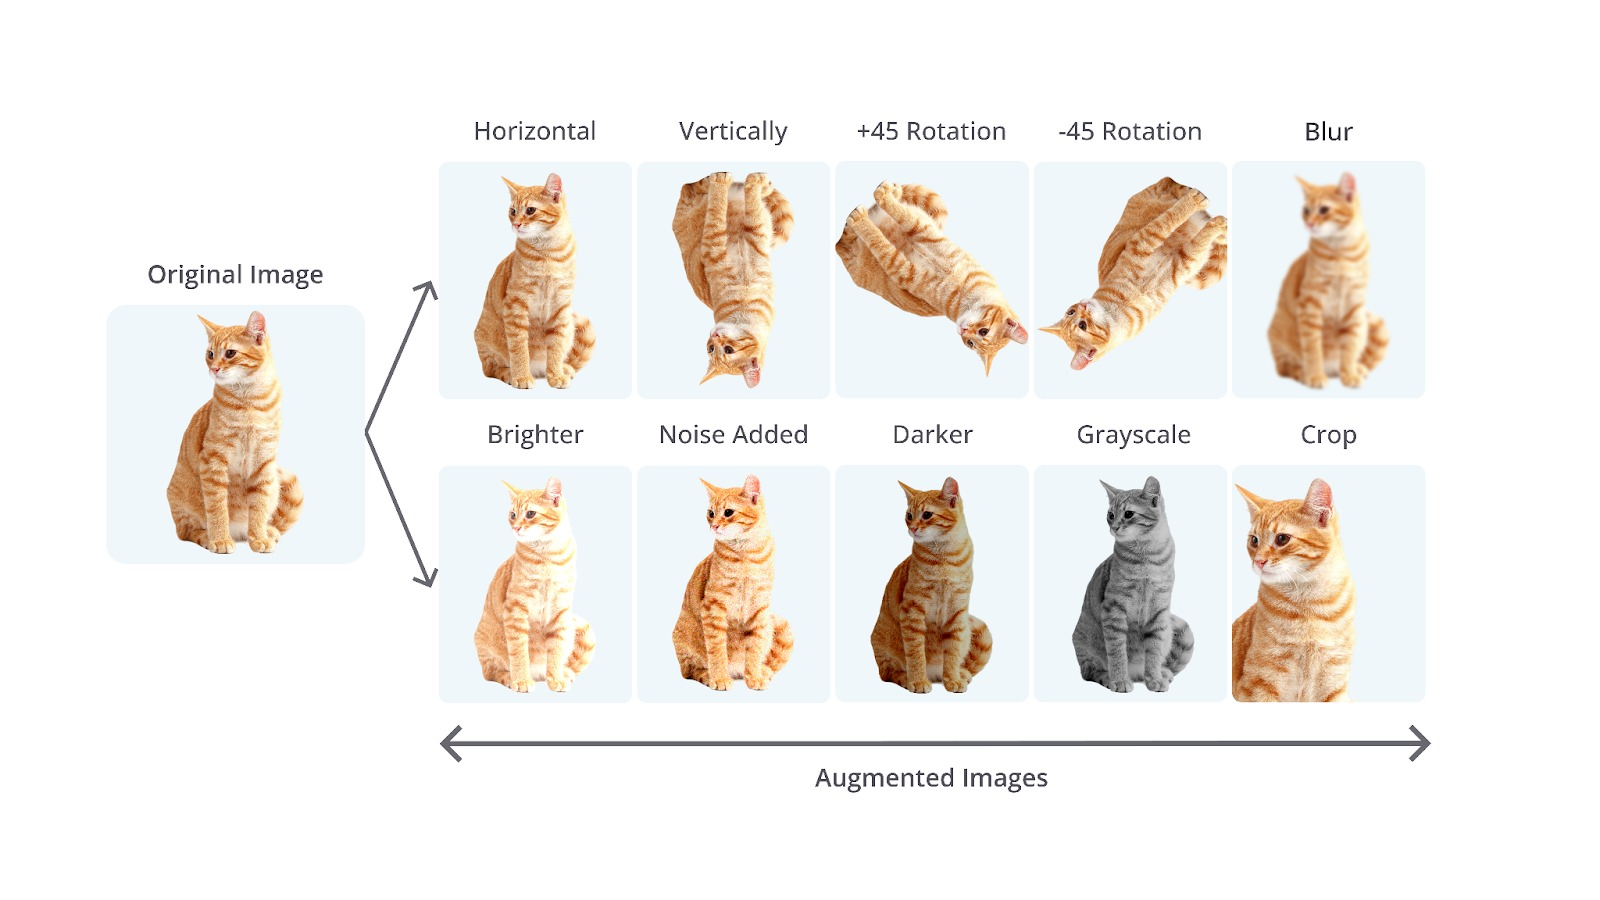

gambar di atas sebagai contoh augmentasi

# **U-Net**

In [ ]:
def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding="same")(x) # ukuran lebar dan tinggi = sama
    x = layers.BatchNormalization()(x) # menstabilkan distribusi aktivasi
    x = layers.ReLU()(x) # layer yang bisa membaca pola non learitas sering di pakai di deep learning
    x = layers.Conv2D(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def unet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), base=32):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, base);     p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, base*2);       p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, base*4);       p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, base*8);       p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, base*16)

    # Decoder
    u4 = layers.Conv2DTranspose(base*8, 2, strides=2, padding="same")(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = conv_block(u4, base*8)

    u3 = layers.Conv2DTranspose(base*4, 2, strides=2, padding="same")(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, base*4)

    u2 = layers.Conv2DTranspose(base*2, 2, strides=2, padding="same")(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, base*2)

    u1 = layers.Conv2DTranspose(base, 2, strides=2, padding="same")(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, base)

    outputs = layers.Conv2D(1, 1, activation=None)(c8)  # logit 1 channel
    return models.Model(inputs, outputs, name="U-Net")

model = unet()
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# Dice loss = mengukur seberapa besar tumpang tindih (overlap) antara area prediksi dan area sebenarnya (mask ground truth)
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)           # dari logit -> probabilitas
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2.*inter + smooth) / (denom + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# IoU = juga mengukur overlap, tapi sedikit lebih ketat daripada Dice.
def iou_metric(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

# Kombinasi loss: BCE + Dice (sering stabil)
def bce_dice(y_true, y_pred, bce_weight=0.5):
    bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    bce = tf.reduce_mean(bce)
    return bce_weight*bce + (1.0-bce_weight)*dice_loss(y_true, y_pred)

pixel_acc = tf.keras.metrics.BinaryAccuracy(name="pixel_accuracy", threshold=0.5)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3), # adam optimizer
    loss=bce_dice,
    metrics=[iou_metric, dice_coef, pixel_acc]
)


In [ ]:
# Training
ckpt = ModelCheckpoint("unet_best.h5", monitor="val_dice_coef", mode="max", #unet_best.h5 tempat dimana kita menyimpan hasil - monitor = indikator performa yg di pantau
                       save_best_only=True, verbose=1) # save_best_only menyimpan model terbaik - verbose untuk nampilin model ketika di simpan
early = EarlyStopping(monitor="val_dice_coef", mode="max", patience=10, restore_best_weights=True)
rlr   = ReduceLROnPlateau(monitor="val_dice_coef", mode="max", factor=0.5, patience=4, min_lr=1e-6, verbose=1)

EPOCHS = 30
hist = model.fit(train_gen,
                 validation_data=val_gen,
                 epochs=EPOCHS,
                 callbacks=[ckpt, early, rlr])


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - dice_coef: 0.6161 - iou_metric: 0.4516 - loss: 0.4502 - pixel_accuracy: 0.7363
Epoch 1: val_dice_coef improved from -inf to 0.41788, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 63s 649ms/step - dice_coef: 0.6180 - iou_metric: 0.4536 - loss: 0.4483 - pixel_accuracy: 0.7382 - val_dice_coef: 0.4179 - val_iou_metric: 0.2649 - val_loss: 0.6245 - val_pixel_accuracy: 0.6283 - learning_rate: 0.0010
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - dice_coef: 0.7120 - iou_metric: 0.5547 - loss: 0.3473 - pixel_accuracy: 0.8277
Epoch 2: val_dice_coef improved from 0.41788 to 0.53377, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - dice_coef: 0.7123 - iou_metric: 0.5551 - loss: 0.3472 - pixel_accuracy: 0.8276 - val_dice_coef: 0.5338 - val_iou_metric: 0.3671 - val_loss: 0.9610 - val_pixel_accuracy: 0.3785 - learning_rate: 0.0010
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - dice_coef: 0.7467 - iou_metric: 0.5979 - loss: 0.3138 - pixel_accuracy: 0.8371
Epoch 3: val_dice_coef improved from 0.53377 to 0.54009, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - dice_coef: 0.7464 - iou_metric: 0.5975 - loss: 0.3142 - pixel_accuracy: 0.8371 - val_dice_coef: 0.5401 - val_iou_metric: 0.3733 - val_loss: 1.2270 - val_pixel_accuracy: 0.3785 - learning_rate: 0.0010
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - dice_coef: 0.7415 - iou_metric: 0.5909 - loss: 0.3135 - pixel_accuracy: 0.8429
Epoch 4: val_dice_coef improved from 0.54009 to 0.54202, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - dice_coef: 0.7416 - iou_metric: 0.5911 - loss: 0.3134 - pixel_accuracy: 0.8428 - val_dice_coef: 0.5420 - val_iou_metric: 0.3752 - val_loss: 1.3339 - val_pixel_accuracy: 0.3785 - learning_rate: 0.0010
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - dice_coef: 0.7603 - iou_metric: 0.6152 - loss: 0.3061 - pixel_accuracy: 0.8488
Epoch 5: val_dice_coef did not improve from 0.54202
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - dice_coef: 0.7598 - iou_metric: 0.6146 - loss: 0.3065 - pixel_accuracy: 0.8486 - val_dice_coef: 0.5409 - val_iou_metric: 0.3742 - val_loss: 2.0756 - val_pixel_accuracy: 0.3785 - learning_rate: 0.0010
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - dice_coef: 0.7519 - iou_metric: 0.6044 - loss: 0.3022 - pixel_accuracy: 0.8556
Epoch 6: val_dice_coef did not improve from 0.54202
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - dice_coef: 0.7522 - iou_metric: 0.6048 - loss: 0.3021 - pixel_accuracy: 0.8555 - val_dice_coef: 0.541

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - dice_coef: 0.7494 - iou_metric: 0.6011 - loss: 0.3128 - pixel_accuracy: 0.8399 - val_dice_coef: 0.5427 - val_iou_metric: 0.3758 - val_loss: 1.3039 - val_pixel_accuracy: 0.3788 - learning_rate: 0.0010
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - dice_coef: 0.7644 - iou_metric: 0.6202 - loss: 0.2958 - pixel_accuracy: 0.8519
Epoch 9: val_dice_coef improved from 0.54272 to 0.56397, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - dice_coef: 0.7643 - iou_metric: 0.6201 - loss: 0.2960 - pixel_accuracy: 0.8518 - val_dice_coef: 0.5640 - val_iou_metric: 0.3959 - val_loss: 1.4721 - val_pixel_accuracy: 0.4496 - learning_rate: 0.0010
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - dice_coef: 0.7582 - iou_metric: 0.6124 - loss: 0.2928 - pixel_accuracy: 0.8542
Epoch 10: val_dice_coef improved from 0.56397 to 0.56860, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - dice_coef: 0.7585 - iou_metric: 0.6128 - loss: 0.2927 - pixel_accuracy: 0.8542 - val_dice_coef: 0.5686 - val_iou_metric: 0.4009 - val_loss: 1.1790 - val_pixel_accuracy: 0.4945 - learning_rate: 0.0010
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - dice_coef: 0.7802 - iou_metric: 0.6414 - loss: 0.2869 - pixel_accuracy: 0.8506
Epoch 11: val_dice_coef improved from 0.56860 to 0.58002, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - dice_coef: 0.7798 - iou_metric: 0.6409 - loss: 0.2868 - pixel_accuracy: 0.8508 - val_dice_coef: 0.5800 - val_iou_metric: 0.4116 - val_loss: 1.6503 - val_pixel_accuracy: 0.5003 - learning_rate: 0.0010
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - dice_coef: 0.7817 - iou_metric: 0.6426 - loss: 0.2731 - pixel_accuracy: 0.8598
Epoch 12: val_dice_coef improved from 0.58002 to 0.58954, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - dice_coef: 0.7815 - iou_metric: 0.6424 - loss: 0.2735 - pixel_accuracy: 0.8597 - val_dice_coef: 0.5895 - val_iou_metric: 0.4214 - val_loss: 0.7592 - val_pixel_accuracy: 0.5822 - learning_rate: 0.0010
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - dice_coef: 0.7689 - iou_metric: 0.6273 - loss: 0.2943 - pixel_accuracy: 0.8495
Epoch 13: val_dice_coef did not improve from 0.58954
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - dice_coef: 0.7690 - iou_metric: 0.6275 - loss: 0.2939 - pixel_accuracy: 0.8498 - val_dice_coef: 0.5756 - val_iou_metric: 0.4071 - val_loss: 1.6553 - val_pixel_accuracy: 0.4797 - learning_rate: 0.0010
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - dice_coef: 0.7879 - iou_metric: 0.6518 - loss: 0.2754 - pixel_accuracy: 0.8648
Epoch 14: val_dice_coef improved from 0.58954 to 0.64587, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - dice_coef: 0.7876 - iou_metric: 0.6513 - loss: 0.2756 - pixel_accuracy: 0.8647 - val_dice_coef: 0.6459 - val_iou_metric: 0.4803 - val_loss: 0.9253 - val_pixel_accuracy: 0.6882 - learning_rate: 0.0010
Epoch 15/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - dice_coef: 0.7625 - iou_metric: 0.6186 - loss: 0.2846 - pixel_accuracy: 0.8647
Epoch 15: val_dice_coef did not improve from 0.64587
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - dice_coef: 0.7634 - iou_metric: 0.6198 - loss: 0.2839 - pixel_accuracy: 0.8648 - val_dice_coef: 0.6449 - val_iou_metric: 0.4799 - val_loss: 0.5997 - val_pixel_accuracy: 0.7617 - learning_rate: 0.0010
Epoch 16/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - dice_coef: 0.7750 - iou_metric: 0.6347 - loss: 0.2838 - pixel_accuracy: 0.8603
Epoch 16: val_dice_coef did not improve from 0.64587
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - dice_coef: 0.7754 - iou_metric: 0.6352 - loss: 0.2832 - pixel_accuracy: 0.8605 - val_dice_coef: 0

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step - dice_coef: 0.8039 - iou_metric: 0.6733 - loss: 0.2480 - pixel_accuracy: 0.8769 - val_dice_coef: 0.6730 - val_iou_metric: 0.5094 - val_loss: 0.4209 - val_pixel_accuracy: 0.7994 - learning_rate: 0.0010
Epoch 18/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - dice_coef: 0.7881 - iou_metric: 0.6519 - loss: 0.2705 - pixel_accuracy: 0.8714
Epoch 18: val_dice_coef did not improve from 0.67305
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - dice_coef: 0.7882 - iou_metric: 0.6521 - loss: 0.2703 - pixel_accuracy: 0.8713 - val_dice_coef: 0.6558 - val_iou_metric: 0.4887 - val_loss: 0.3918 - val_pixel_accuracy: 0.8151 - learning_rate: 0.0010
Epoch 19/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - dice_coef: 0.7875 - iou_metric: 0.6513 - loss: 0.2695 - pixel_accuracy: 0.8693
Epoch 19: val_dice_coef improved from 0.67305 to 0.69704, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - dice_coef: 0.7877 - iou_metric: 0.6515 - loss: 0.2694 - pixel_accuracy: 0.8693 - val_dice_coef: 0.6970 - val_iou_metric: 0.5397 - val_loss: 0.4661 - val_pixel_accuracy: 0.8216 - learning_rate: 0.0010
Epoch 20/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - dice_coef: 0.7936 - iou_metric: 0.6586 - loss: 0.2662 - pixel_accuracy: 0.8713
Epoch 20: val_dice_coef improved from 0.69704 to 0.75373, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - dice_coef: 0.7936 - iou_metric: 0.6586 - loss: 0.2661 - pixel_accuracy: 0.8712 - val_dice_coef: 0.7537 - val_iou_metric: 0.6057 - val_loss: 0.3180 - val_pixel_accuracy: 0.8525 - learning_rate: 0.0010
Epoch 21/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - dice_coef: 0.7830 - iou_metric: 0.6460 - loss: 0.2711 - pixel_accuracy: 0.8711
Epoch 21: val_dice_coef did not improve from 0.75373
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - dice_coef: 0.7834 - iou_metric: 0.6465 - loss: 0.2708 - pixel_accuracy: 0.8711 - val_dice_coef: 0.6875 - val_iou_metric: 0.5248 - val_loss: 0.3880 - val_pixel_accuracy: 0.8026 - learning_rate: 0.0010
Epoch 22/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - dice_coef: 0.7979 - iou_metric: 0.6654 - loss: 0.2656 - pixel_accuracy: 0.8722
Epoch 22: val_dice_coef did not improve from 0.75373
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - dice_coef: 0.7980 - iou_metric: 0.6657 - loss: 0.2651 - pixel_accuracy: 0.8724 - val_dice_coef: 0

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - dice_coef: 0.8077 - iou_metric: 0.6792 - loss: 0.2397 - pixel_accuracy: 0.8848 - val_dice_coef: 0.7782 - val_iou_metric: 0.6378 - val_loss: 0.2785 - val_pixel_accuracy: 0.8693 - learning_rate: 0.0010
Epoch 24/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - dice_coef: 0.8064 - iou_metric: 0.6770 - loss: 0.2539 - pixel_accuracy: 0.8778
Epoch 24: val_dice_coef improved from 0.77818 to 0.77955, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - dice_coef: 0.8062 - iou_metric: 0.6769 - loss: 0.2539 - pixel_accuracy: 0.8778 - val_dice_coef: 0.7795 - val_iou_metric: 0.6393 - val_loss: 0.3053 - val_pixel_accuracy: 0.8622 - learning_rate: 0.0010
Epoch 25/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - dice_coef: 0.8021 - iou_metric: 0.6709 - loss: 0.2505 - pixel_accuracy: 0.8741
Epoch 25: val_dice_coef did not improve from 0.77955
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - dice_coef: 0.8021 - iou_metric: 0.6709 - loss: 0.2507 - pixel_accuracy: 0.8741 - val_dice_coef: 0.7462 - val_iou_metric: 0.5957 - val_loss: 0.3305 - val_pixel_accuracy: 0.8543 - learning_rate: 0.0010
Epoch 26/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - dice_coef: 0.8139 - iou_metric: 0.6871 - loss: 0.2457 - pixel_accuracy: 0.8784
Epoch 26: val_dice_coef did not improve from 0.77955
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - dice_coef: 0.8138 - iou_metric: 0.6869 - loss: 0.2456 - pixel_accuracy: 0.8786 - val_dice_coef: 

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - dice_coef: 0.8084 - iou_metric: 0.6798 - loss: 0.2421 - pixel_accuracy: 0.8819 - val_dice_coef: 0.7801 - val_iou_metric: 0.6403 - val_loss: 0.3121 - val_pixel_accuracy: 0.8519 - learning_rate: 0.0010
Epoch 29/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - dice_coef: 0.8306 - iou_metric: 0.7113 - loss: 0.2142 - pixel_accuracy: 0.8967
Epoch 29: val_dice_coef did not improve from 0.78013
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - dice_coef: 0.8305 - iou_metric: 0.7111 - loss: 0.2146 - pixel_accuracy: 0.8966 - val_dice_coef: 0.7732 - val_iou_metric: 0.6310 - val_loss: 0.2886 - val_pixel_accuracy: 0.8629 - learning_rate: 0.0010
Epoch 30/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - dice_coef: 0.8230 - iou_metric: 0.7000 - loss: 0.2373 - pixel_accuracy: 0.8841
Epoch 30: val_dice_coef improved from 0.78013 to 0.79812, saving model to unet_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - dice_coef: 0.8229 - iou_metric: 0.6998 - loss: 0.2371 - pixel_accuracy: 0.8842 - val_dice_coef: 0.7981 - val_iou_metric: 0.6648 - val_loss: 0.3250 - val_pixel_accuracy: 0.8660 - learning_rate: 0.0010


In [ ]:
# muat bobot terbaik yang tadi sudah di simpan
model.load_weights("unet_best.h5")

test_metrics = model.evaluate(test_gen, verbose=0)
print(dict(zip(model.metrics_names, test_metrics)))


{'loss': 0.32488569617271423, 'compile_metrics': 0.6874194741249084}


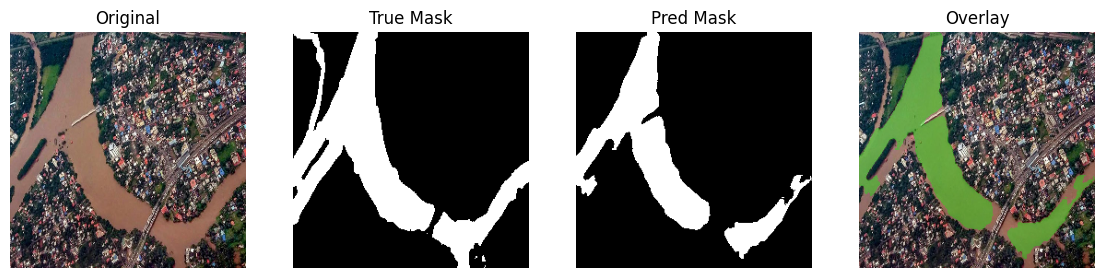

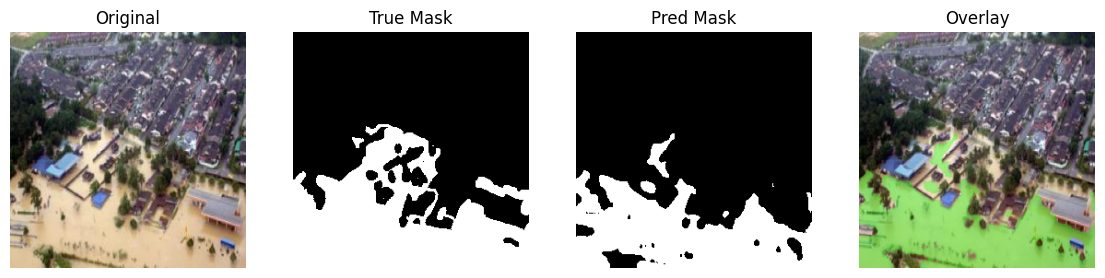

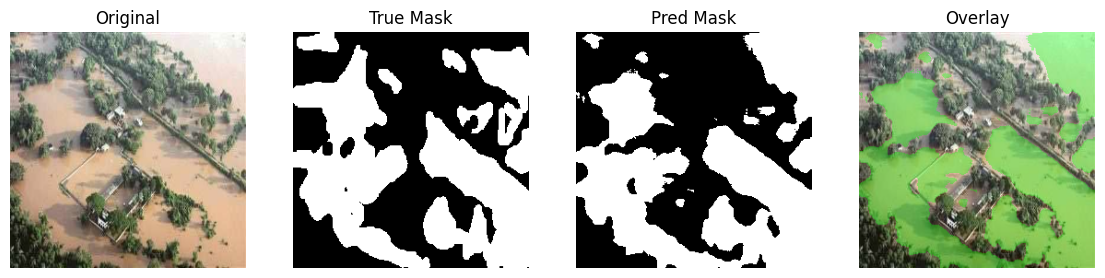

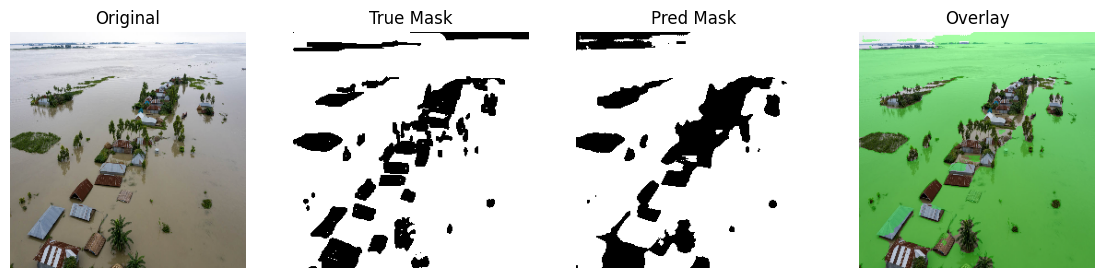

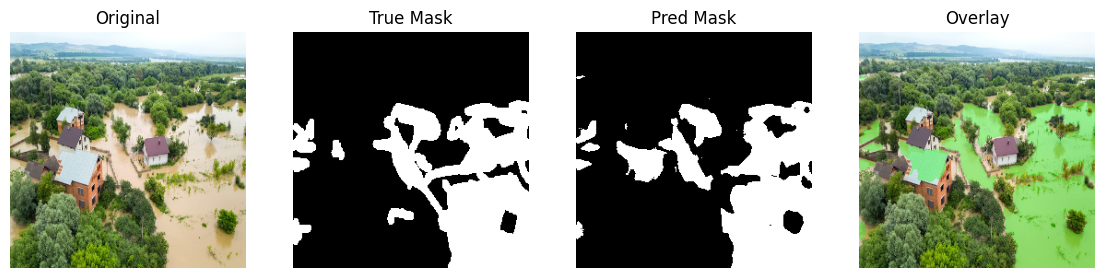

Nama Gambar            |   IoU   |  Dice  |  Acc 
1081.jpg               |   0.724 |  0.840 | 0.932
3092.jpg               |   0.725 |  0.841 | 0.905
1042.jpg               |   0.735 |  0.848 | 0.851
3009.jpg               |   0.886 |  0.940 | 0.902
2042.jpg               |   0.766 |  0.868 | 0.926

Mean (N=5) — IoU: 0.767, Dice: 0.867, Acc: 0.903


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Prediksi -> probabilitas & mask biner 2D (H,W)
def predict_mask(img_rgb):
    """
    img_rgb: (H,W,3) float 0..1
    return: prob2d (H,W) float 0..1, pred2d (H,W) uint8 {0,1}
    """
    logit = model.predict(img_rgb[None, ...], verbose=0)[0]   # (H,W,1)
    # sigmoid
    prob = 1.0 / (1.0 + np.exp(-logit))
    # pastikan 2D
    if prob.ndim == 3 and prob.shape[-1] == 1:
        prob2d = prob[..., 0]
    else:
        prob2d = prob
    pred2d = (prob2d > 0.5).astype(np.uint8)
    return prob2d, pred2d

# 2) Overlay aman
def overlay_rgb(img_rgb, mask01, alpha=0.35, color=(0, 255, 0)):
    """
    img_rgb: (H,W,3) float 0..1 atau uint8 0..255
    mask01 : (H,W) atau (H,W,1) {0,1}
    return : (H,W,3) uint8
    """
    # rapikan bentuk mask
    if mask01.ndim == 3 and mask01.shape[-1] == 1:
        mask01 = mask01[..., 0]
    mask2 = (mask01 > 0)

    # pastikan tipe citra uint8 0..255
    if img_rgb.dtype != np.uint8:
        out = (img_rgb * 255.0).clip(0, 255).astype(np.uint8)
    else:
        out = img_rgb.copy()

    # blend hanya di piksel bertopeng
    region = out[mask2, :].astype(np.float32)              # (N,3)
    color  = np.array(color, dtype=np.float32)             # (3,)
    region = (1.0 - alpha) * region + alpha * color
    out[mask2, :] = region.clip(0, 255).astype(np.uint8)
    return out

# 3) Metrik (IoU, Dice, Accuracy)
def iou_dice_acc(pred01, gt01):
    """
    pred01, gt01: (H,W) {0,1}
    """
    pred = pred01.astype(bool)
    gt   = gt01.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    iou  = inter / (union + 1e-9)
    dice = 2 * inter / (pred.sum() + gt.sum() + 1e-9)
    acc  = (pred01 == gt01).mean()
    return iou, dice, acc

# 4) Tampilkan N sampel: Original | True | Pred | Overlay + tabel metrik ---
N = min(5, len(X_test))
rows = []

for i in range(N):
    p_img, p_mask = X_test[i], y_test[i]

    # baca data
    img = read_image(p_img)                          # (H,W,3) float 0..1
    gt  = read_mask(p_mask)[..., 0].astype(np.uint8) # (H,W) {0,1}

    # prediksi
    prob, pred = predict_mask(img)                   # (H,W) float, (H,W) uint8

    # metrik
    iou, dice, acc = iou_dice_acc(pred, gt)
    rows.append((os.path.basename(p_img), iou, dice, acc))

    # overlay
    ov = overlay_rgb(img, pred, alpha=0.35, color=(0,255,0))

    # panel
    plt.figure(figsize=(14,4))
    plt.subplot(1,4,1); plt.imshow(img);  plt.title("Original");   plt.axis('off')
    plt.subplot(1,4,2); plt.imshow(gt, cmap='gray');   plt.title("True Mask"); plt.axis('off')
    plt.subplot(1,4,3); plt.imshow(pred, cmap='gray'); plt.title("Pred Mask"); plt.axis('off')
    plt.subplot(1,4,4); plt.imshow(ov);   plt.title("Overlay");    plt.axis('off')
    plt.show()

# --- 5) Tabel ringkas + rata-rata ---
print("Nama Gambar            |   IoU   |  Dice  |  Acc ")
for name, iou, dice, acc in rows:
    print(f"{name:22s} | {iou:7.3f} | {dice:6.3f} | {acc:5.3f}")

mean_iou  = np.mean([r[1] for r in rows])
mean_dice = np.mean([r[2] for r in rows])
mean_acc  = np.mean([r[3] for r in rows])
print(f"\nMean (N={len(rows)}) — IoU: {mean_iou:.3f}, Dice: {mean_dice:.3f}, Acc: {mean_acc:.3f}")


# **DeepLabv3**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.resnet50 import preprocess_input

def deeplabv3plus(input_shape=(256,256,3), num_classes=1, freeze_backbone=True):
    # Backbone ResNet50 (ImageNet), keluaran stride 16 & stride 4
    base = tf.keras.applications.ResNet50(
        input_shape=input_shape, include_top=False, weights='imagenet')
    if freeze_backbone:
        base.trainable = False  # bisa di-unfreeze sebagian setelah stabil

    # TAP YANG BENAR:
    # high-level (H/16), low-level (H/4)
    x_high = base.get_layer('conv4_block6_out').output   # H/16
    x_low  = base.get_layer('conv2_block3_out').output   # H/4

    # ASPP di H/16
    def ASPP(x):
        b0 = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
        b0 = layers.BatchNormalization()(b0); b0 = layers.ReLU()(b0)

        b1 = layers.Conv2D(256, 3, padding='same', dilation_rate=6,  use_bias=False)(x)
        b1 = layers.BatchNormalization()(b1); b1 = layers.ReLU()(b1)

        b2 = layers.Conv2D(256, 3, padding='same', dilation_rate=12, use_bias=False)(x)
        b2 = layers.BatchNormalization()(b2); b2 = layers.ReLU()(b2)

        b3 = layers.Conv2D(256, 3, padding='same', dilation_rate=18, use_bias=False)(x)
        b3 = layers.BatchNormalization()(b3); b3 = layers.ReLU()(b3)

        y = layers.Concatenate()([b0, b1, b2, b3])
        y = layers.Conv2D(256, 1, padding='same', use_bias=False)(y)
        y = layers.BatchNormalization()(y); y = layers.ReLU()(y)
        return y

    inp = layers.Input(shape=input_shape)
    # Gunakan preprocess_input khusus ResNet50 (mode 'tf' → [-1,1])
    x_in = layers.Lambda(preprocess_input, name='resnet50_preproc')(inp)

    backbone = Model(inputs=base.input, outputs=[x_high, x_low], name='resnet50_backbone')
    h16, h4 = backbone(x_in)                 # h16: H/16 (ASPP), h4: H/4 (low-level)

    y = ASPP(h16)                            # H/16
    y = layers.UpSampling2D((4,4), interpolation='bilinear')(y)  # → H/4

    # Proyeksi low-level agar channel kecil
    h4p = layers.Conv2D(48, 1, padding='same', use_bias=False)(h4)
    h4p = layers.BatchNormalization()(h4p); h4p = layers.ReLU()(h4p)

    y = layers.Concatenate()([y, h4p])       # keduanya H/4
    y = layers.Conv2D(256, 3, padding='same', use_bias=False)(y)
    y = layers.BatchNormalization()(y); y = layers.ReLU()(y)
    y = layers.Conv2D(256, 3, padding='same', use_bias=False)(y)
    y = layers.BatchNormalization()(y); y = layers.ReLU()(y)

    y = layers.UpSampling2D((4,4), interpolation='bilinear')(y)  # → H/1
    out = layers.Conv2D(num_classes, 1, activation=None)(y)      # logit

    return Model(inp, out, name='DeepLabv3Plus')


In [ ]:
model2 = deeplabv3plus(input_shape=(256,256,3), num_classes=1, freeze_backbone=True)
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
               loss=bce_dice,
               metrics=[iou_metric, dice_coef, pixel_acc])

ckpt2 = ModelCheckpoint("deeplabv3plus_best.h5", monitor="val_dice_coef",
                        mode="max", save_best_only=True, verbose=1)
early2 = EarlyStopping(monitor="val_dice_coef", mode="max",
                       patience=10, restore_best_weights=True)
rlr2   = ReduceLROnPlateau(monitor="val_dice_coef", mode="max",
                           factor=0.5, patience=4, min_lr=1e-6, verbose=1)

hist2 = model2.fit(train_gen, validation_data=val_gen,
                   epochs=EPOCHS, callbacks=[ckpt2, early2, rlr2])

model2.load_weights("deeplabv3plus_best.h5")


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - dice_coef: 0.4631 - iou_metric: 0.3032 - loss: 0.7690 - pixel_accuracy: 0.6610
Epoch 1: val_dice_coef improved from -inf to 0.48914, saving model to deeplabv3plus_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - dice_coef: 0.4640 - iou_metric: 0.3039 - loss: 0.7649 - pixel_accuracy: 0.6605 - val_dice_coef: 0.4891 - val_iou_metric: 0.3257 - val_loss: 1.7971 - val_pixel_accuracy: 0.3851 - learning_rate: 0.0010
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - dice_coef: 0.5871 - iou_metric: 0.4186 - loss: 0.4793 - pixel_accuracy: 0.7341
Epoch 2: val_dice_coef improved from 0.48914 to 0.54561, saving model to deeplabv3plus_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - dice_coef: 0.5882 - iou_metric: 0.4197 - loss: 0.4783 - pixel_accuracy: 0.7347 - val_dice_coef: 0.5456 - val_iou_metric: 0.3787 - val_loss: 1.8575 - val_pixel_accuracy: 0.3839 - learning_rate: 0.0010
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - dice_coef: 0.6882 - iou_metric: 0.5260 - loss: 0.3847 - pixel_accuracy: 0.7880
Epoch 3: val_dice_coef improved from 0.54561 to 0.59325, saving model to deeplabv3plus_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - dice_coef: 0.6876 - iou_metric: 0.5253 - loss: 0.3854 - pixel_accuracy: 0.7879 - val_dice_coef: 0.5932 - val_iou_metric: 0.4249 - val_loss: 0.4885 - val_pixel_accuracy: 0.7494 - learning_rate: 0.0010
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - dice_coef: 0.6551 - iou_metric: 0.4899 - loss: 0.4066 - pixel_accuracy: 0.7858
Epoch 4: val_dice_coef improved from 0.59325 to 0.60661, saving model to deeplabv3plus_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - dice_coef: 0.6559 - iou_metric: 0.4908 - loss: 0.4060 - pixel_accuracy: 0.7860 - val_dice_coef: 0.6066 - val_iou_metric: 0.4386 - val_loss: 0.5963 - val_pixel_accuracy: 0.6559 - learning_rate: 0.0010
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - dice_coef: 0.7175 - iou_metric: 0.5620 - loss: 0.3635 - pixel_accuracy: 0.8102
Epoch 5: val_dice_coef did not improve from 0.60661
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - dice_coef: 0.7166 - iou_metric: 0.5610 - loss: 0.3643 - pixel_accuracy: 0.8098 - val_dice_coef: 0.5854 - val_iou_metric: 0.4161 - val_loss: 0.4614 - val_pixel_accuracy: 0.7905 - learning_rate: 0.0010
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - dice_coef: 0.6884 - iou_metric: 0.5263 - loss: 0.3796 - pixel_accuracy: 0.8007
Epoch 6: val_dice_coef did not improve from 0.60661
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - dice_coef: 0.6884 - iou_metric: 0.5263 - loss: 0.3797 - pixel_accuracy: 0.8006 - val_dice_coef: 0.285

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - dice_coef: 0.7016 - iou_metric: 0.5431 - loss: 0.3654 - pixel_accuracy: 0.8125 - val_dice_coef: 0.6488 - val_iou_metric: 0.4830 - val_loss: 0.5472 - val_pixel_accuracy: 0.7119 - learning_rate: 5.0000e-04
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - dice_coef: 0.7251 - iou_metric: 0.5718 - loss: 0.3511 - pixel_accuracy: 0.8152
Epoch 12: val_dice_coef improved from 0.64877 to 0.68605, saving model to deeplabv3plus_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step - dice_coef: 0.7249 - iou_metric: 0.5715 - loss: 0.3512 - pixel_accuracy: 0.8153 - val_dice_coef: 0.6861 - val_iou_metric: 0.5247 - val_loss: 0.4196 - val_pixel_accuracy: 0.7918 - learning_rate: 5.0000e-04
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - dice_coef: 0.7279 - iou_metric: 0.5743 - loss: 0.3432 - pixel_accuracy: 0.8169
Epoch 13: val_dice_coef did not improve from 0.68605
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - dice_coef: 0.7273 - iou_metric: 0.5737 - loss: 0.3437 - pixel_accuracy: 0.8167 - val_dice_coef: 0.6642 - val_iou_metric: 0.4982 - val_loss: 0.4040 - val_pixel_accuracy: 0.7971 - learning_rate: 5.0000e-04
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - dice_coef: 0.7234 - iou_metric: 0.5688 - loss: 0.3523 - pixel_accuracy: 0.8112
Epoch 14: val_dice_coef did not improve from 0.68605
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - dice_coef: 0.7230 - iou_metric: 0.5684 - loss: 0.3524 - pixel_accuracy: 0.8113 - val_dice

Best threshold on val = 0.70 (mean IoU=0.578)
[check] pred.mean=0.200, gt.mean=0.247


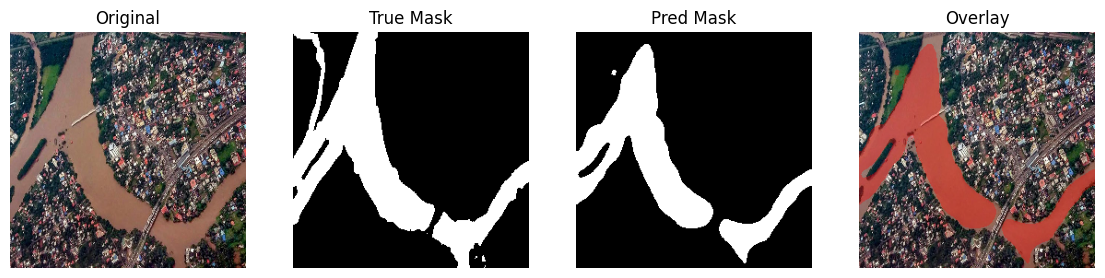

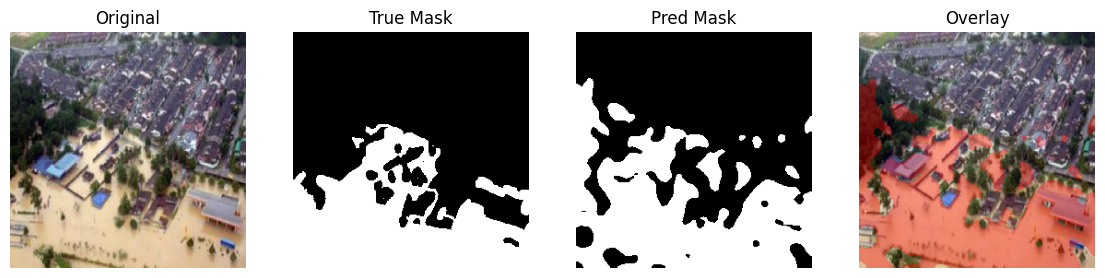

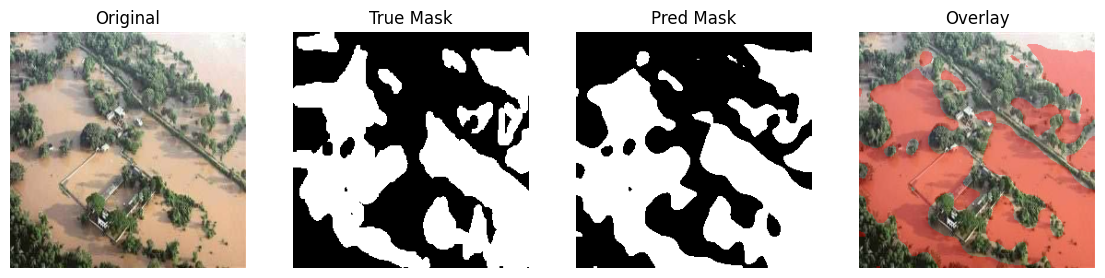

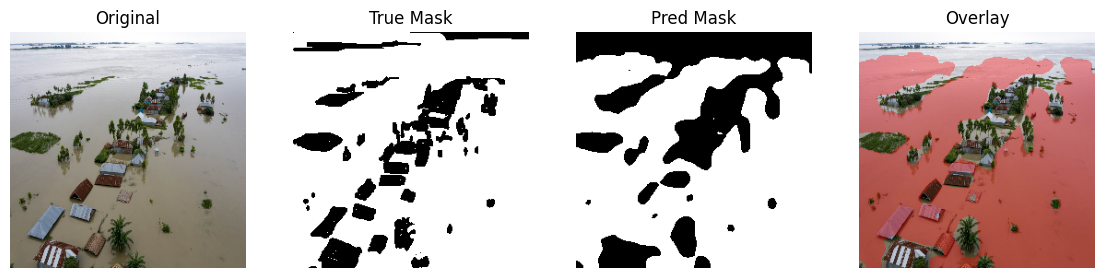

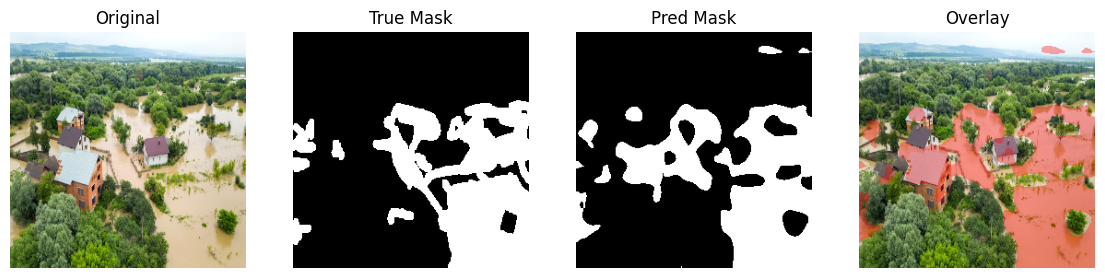

Nama Gambar            |   IoU   |  Dice  |  Pixel Acc 
1081.jpg               |   0.773 |  0.872 |  0.943
3092.jpg               |   0.656 |  0.792 |  0.847
1042.jpg               |   0.759 |  0.863 |  0.864
3009.jpg               |   0.770 |  0.870 |  0.804
2042.jpg               |   0.684 |  0.812 |  0.888

Mean (DeepLabv3+) — IoU: 0.728, Dice: 0.842, PixelAcc: 0.869


In [ ]:
import numpy as np, os, matplotlib.pyplot as plt

# === 2) Cari threshold terbaik di VALIDATION ===
def find_best_threshold(model, Xv, Yv, ts=np.linspace(0.30, 0.70, 9)):
    best = (0.5, -1.0)
    for th in ts:
        ious = []
        for px, py in zip(Xv, Yv):
            img = read_image(px)                              # (H,W,3) float 0..1
            gt  = read_mask(py)[...,0].astype(np.uint8)       # (H,W) {0,1}
            logit = model.predict(img[None,...], verbose=0)[0,...,0]
            prob  = 1/(1+np.exp(-logit))
            pred  = (prob > th).astype(np.uint8)
            iou, _, _ = iou_dice_acc(pred, gt)
            ious.append(iou)
        mean_iou = float(np.mean(ious))
        if mean_iou > best[1]:
            best = (float(th), mean_iou)
    return best

best_th, best_val_iou = find_best_threshold(model2, X_val, y_val)
print(f"Best threshold on val = {best_th:.2f} (mean IoU={best_val_iou:.3f})")

# === 3) Fungsi prediksi dengan threshold terpilih ===
def predict_mask_deeplab(img_rgb, thr):
    logit = model2.predict(img_rgb[None, ...], verbose=0)[0, ..., 0]  # (H,W)
    prob  = 1/(1+np.exp(-logit))                                      # (H,W) 0..1
    pred  = (prob > thr).astype(np.uint8)                              # (H,W) {0,1}
    return prob, pred

# === 4) Evaluasi & visualisasi pada TEST SET ===
N = min(5, len(X_test))
rows = []

for i in range(N):
    p_img, p_mask = X_test[i], y_test[i]
    img = read_image(p_img)
    gt  = read_mask(p_mask)[..., 0].astype(np.uint8)

    prob, pred = predict_mask_deeplab(img, thr=best_th)

    # sanity check cepat
    if i == 0:
        print(f"[check] pred.mean={pred.mean():.3f}, gt.mean={gt.mean():.3f}")

    iou, dice, acc = iou_dice_acc(pred, gt)
    rows.append((os.path.basename(p_img), iou, dice, acc))

    ov = overlay_rgb(img, pred, alpha=0.35, color=(255,0,0))  # merah utk DeepLab
    plt.figure(figsize=(14,4))
    plt.subplot(1,4,1); plt.imshow(img); plt.title("Original"); plt.axis('off')
    plt.subplot(1,4,2); plt.imshow(gt, cmap='gray'); plt.title("True Mask"); plt.axis('off')
    plt.subplot(1,4,3); plt.imshow(pred, cmap='gray'); plt.title("Pred Mask"); plt.axis('off')
    plt.subplot(1,4,4); plt.imshow(ov); plt.title("Overlay"); plt.axis('off')
    plt.show()

# === 5) Tabel metrik & rata-rata ===
print("Nama Gambar            |   IoU   |  Dice  |  Pixel Acc ")
for name, iou, dice, acc in rows:
    print(f"{name:22s} | {iou:7.3f} | {dice:6.3f} | {acc:6.3f}")

mean_iou  = float(np.mean([r[1] for r in rows]))
mean_dice = float(np.mean([r[2] for r in rows]))
mean_acc  = float(np.mean([r[3] for r in rows]))
print(f"\nMean (DeepLabv3+) — IoU: {mean_iou:.3f}, Dice: {mean_dice:.3f}, PixelAcc: {mean_acc:.3f}")